# Goals

* Find simple analytic formulae using symbolic regression that can describe a complex 2D PDF from numerical simulations
* Bonus: a generalized framework for higher-dimensional PDF fitting?

# Twind

* We run a suite of star-forming ISM simulations [Paper I](https://ui.adsabs.harvard.edu/abs/2020ApJ...900...61K/abstract) and characterize multiphase outflows using PDF of outflow velocity and sound speed at different heights [Paper II](https://ui.adsabs.harvard.edu/abs/2020ApJ...903L..34K/abstract).
* We come up with a two-phase PDF model as discribed in Section 3 of [Paper II](https://ui.adsabs.harvard.edu/abs/2020ApJ...903L..34K/abstract) (or see [Twind PDF](https://twind.readthedocs.io/en/latest/user/jointpdfmodel.html)). 
* This is done mostly by eyeballing and fitting compressed 1D PDFs.
* [Twind](https://twind.readthedocs.io/en/latest/index.html) is a python package to provide eaiser access to the simulation data and model PDFs.

## Retrieve simulation PDFs 

In [1]:
import twind

In [2]:
# we have 7 models and 4 selected height at which we calculated 2D pdfs from simulations
models = ['R2', 'R4', 'R8', 'R16', 'LGR2', 'LGR4', 'LGR8']
heights = ['H', '2H', '500', '1000']

In [3]:
# let's work on data at z='H'
# this will download the pdf data files under ./data/pdfs
# data is stored as netCDF4 format created using xarray
# https://docs.xarray.dev/en/stable/getting-started-guide/quick-overview.html?highlight=netcdf#read-write-netcdf-files
sims = twind.TigressSimContainer(z0='H')

In [4]:
# each model is stored as a dictionary of TigressSimLoader
sims.sims

{'R2': <twind.simulation.TigressSimLoader at 0x187ad1d20>,
 'R4': <twind.simulation.TigressSimLoader at 0x103d1d4b0>,
 'R8': <twind.simulation.TigressSimLoader at 0x103d1f6d0>,
 'R16': <twind.simulation.TigressSimLoader at 0x187ad3550>,
 'LGR2': <twind.simulation.TigressSimLoader at 0x187ad3c10>,
 'LGR4': <twind.simulation.TigressSimLoader at 0x187ad3250>,
 'LGR8': <twind.simulation.TigressSimLoader at 0x187ad3f10>}

In [5]:
# each TigrressSimLoader has a member called simpdf for all pdfs calculated from simulations
# this is stored as xarray Dataset
sims.sims['R2'].simpdf

<xarray.Dataset>
Dimensions:  (logcs: 175, logvout: 175)
Coordinates:
  * logcs    (logcs) float64 0.0 0.02 0.04 0.06 0.08 ... 3.4 3.42 3.44 3.46 3.48
  * logvout  (logvout) float64 0.0 0.02 0.04 0.06 0.08 ... 3.42 3.44 3.46 3.48
Data variables: (12/13)
    volume   (logcs, logvout) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    density  (logcs, logvout) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Mpdf     (logcs, logvout) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Zpdf     (logcs, logvout) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Epdf     (logcs, logvout) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Z        (logcs, logvout) float64 nan nan nan nan nan ... nan nan nan nan
    ...       ...
    ppdf     (logcs, logvout) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    vBz      (logcs, logvout) float64 2.449 2.469 2.49 ... 7.343e+03 7.397e+03
    Mach     (logcs, logvout) float64 1.0 1.047 1.096 1.148 ... 0.912 0.955 1.0
    ppdf_r   (logcs, logvout) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Epdf_r   (logcs, logvout) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Zpdf_r   (logcs, logvout) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/26)
    volume:           28009870.0
    dVol:             8.0
    density:          12854352.0
    massflux:         536483031.3792453
    metalflux:        23569370.822659124
    energyflux:       82253874883674.94
    ...               ...
    energy_ref:       1.0471204188481676e+49
    metal_ref:        0.020942408376963352
    etaM:             1.2205235128846412
    etap:             0.20479119918321576
    etaE:             0.3553495816056261
    etaZ:             2.560421854819976

In [6]:
# Now, let's collect only relevant information across the models
# we are only interested in fitting the mass flux PDF (other PDFs can be reconstructed from it)
# I use xarray to handle the data
import xarray as xr
mpdf = xr.Dataset()
for mdl in models:
    mpdf[mdl]=sims.sims[mdl].simpdf['Mpdf']

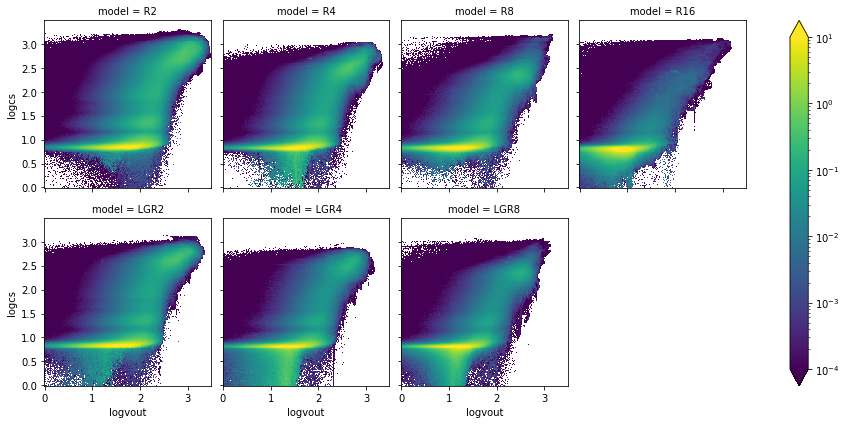

In [7]:
# glancing the simulation PDFs
from matplotlib.colors import LogNorm
mpdf.to_array('model').plot(col='model',col_wrap=4,norm=LogNorm(1.e-4,10))

## Note
* fitting the simulation pdfs is not very straightforward as we want to have both cool and hot, but the hot component is not a dominant component for the mass flux pdf

In [8]:
# Now, let's look at our current model PDFs
# TigressSimLoader has a method called build_model to construct model PDFs for a given model
mpdf_model = xr.Dataset()
for mdl in models:
    sim = sims.sims[mdl]
    sim.set_axes(pdf=sim.simpdf)
    modelpdf = sim.build_model()
    mpdf_model[mdl] = modelpdf['Mpdf']

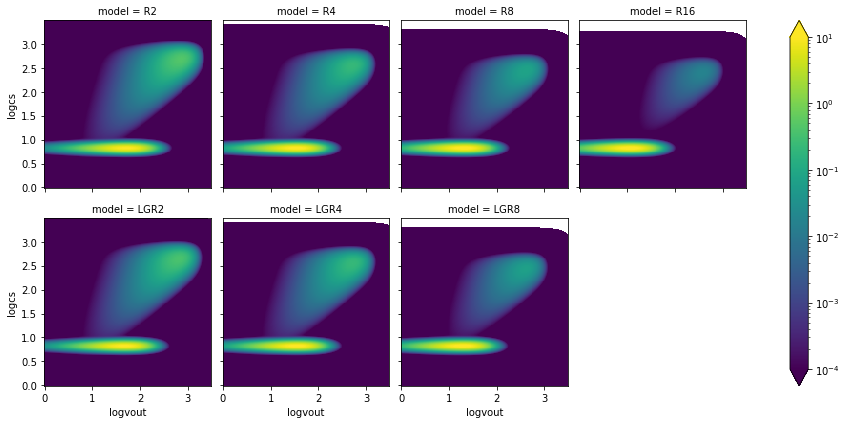

In [9]:
# glancing the model PDFs
from matplotlib.colors import LogNorm
mpdf_model.to_array('model').plot(col='model',col_wrap=4,norm=LogNorm(1.e-4,10))

/Users/ckim/miniconda3/envs/twind-sr/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/ckim/miniconda3/envs/twind-sr/lib/python3.10/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


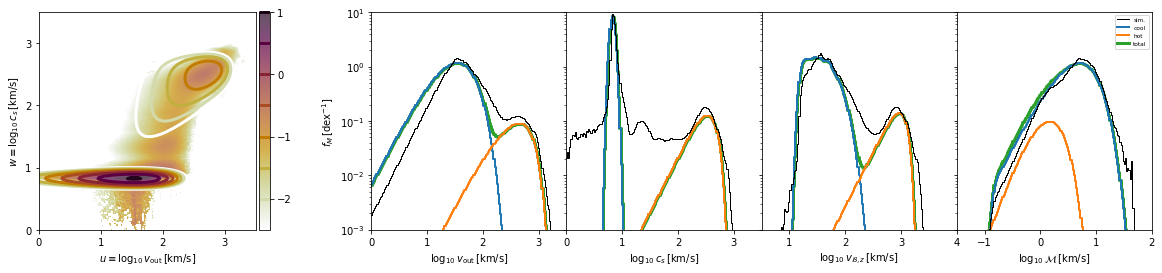

In [10]:
# quick comparison between model and simulation PDFs
from twind.plotter import *
figM=comparison_pdfs(sims.sims['R4'],q='M')

## This is what I have so far. Can you find a better analytic expression with symbolic regression?